<a href="https://colab.research.google.com/github/MattiaGatto/get_formazione_fantacalcio/blob/main/selection_players_serie_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che calcola la miglior rosa da schierare in base ai giocatori acquistati durante l'asta del fantacalcio, basandosi sui dati in real-time presi da [fantacalcio.it](https://www.fantacalcio.it/probabili-formazioni-serie-a).

---
# Librerie necessarie all'utilizzo

In [1]:
!pip install --upgrade pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from bs4 import BeautifulSoup
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Riceverò i dati attraverso il seguente url per la seguente giornata di campionato.



In [2]:
URL = "https://www.fantacalcio.it/probabili-formazioni-serie-a"
resp = requests.get(URL)
print(resp.status_code)
# print(resp.content)

200


---
# Scramping: Trasformare noiosa manualità in prezioso automatismo
### A me personalmente è accaduto in differenti occasioni il dover recuperare da Internet informazioni al fine di poter formare dataset che altrimenti non avrei avuto a disposizione.

### Il modo più semplice sarebbe stato quello di copiare manualmente ogni sinossi e salvarla in un foglio di calcolo. Il compito però diventa semprepiù arduo se si parla di analizzare record nell'ordine delle migliaia, richiederebbe troppi giorni di lavoro macchinoso.

## Analisi di una pagina web per fare scraping
Analizziamo velocemente, usando l’ispezione di Chrome, la pagina Web per individuare le informazioni che ci interessano: digitiamo allora nel campo di ricerca del browser https://www.fantacalcio.it/probabili-formazioni-serie-a e premiamo il tasto F12: dovremmo vedere una cosa simile a quella di seguito:

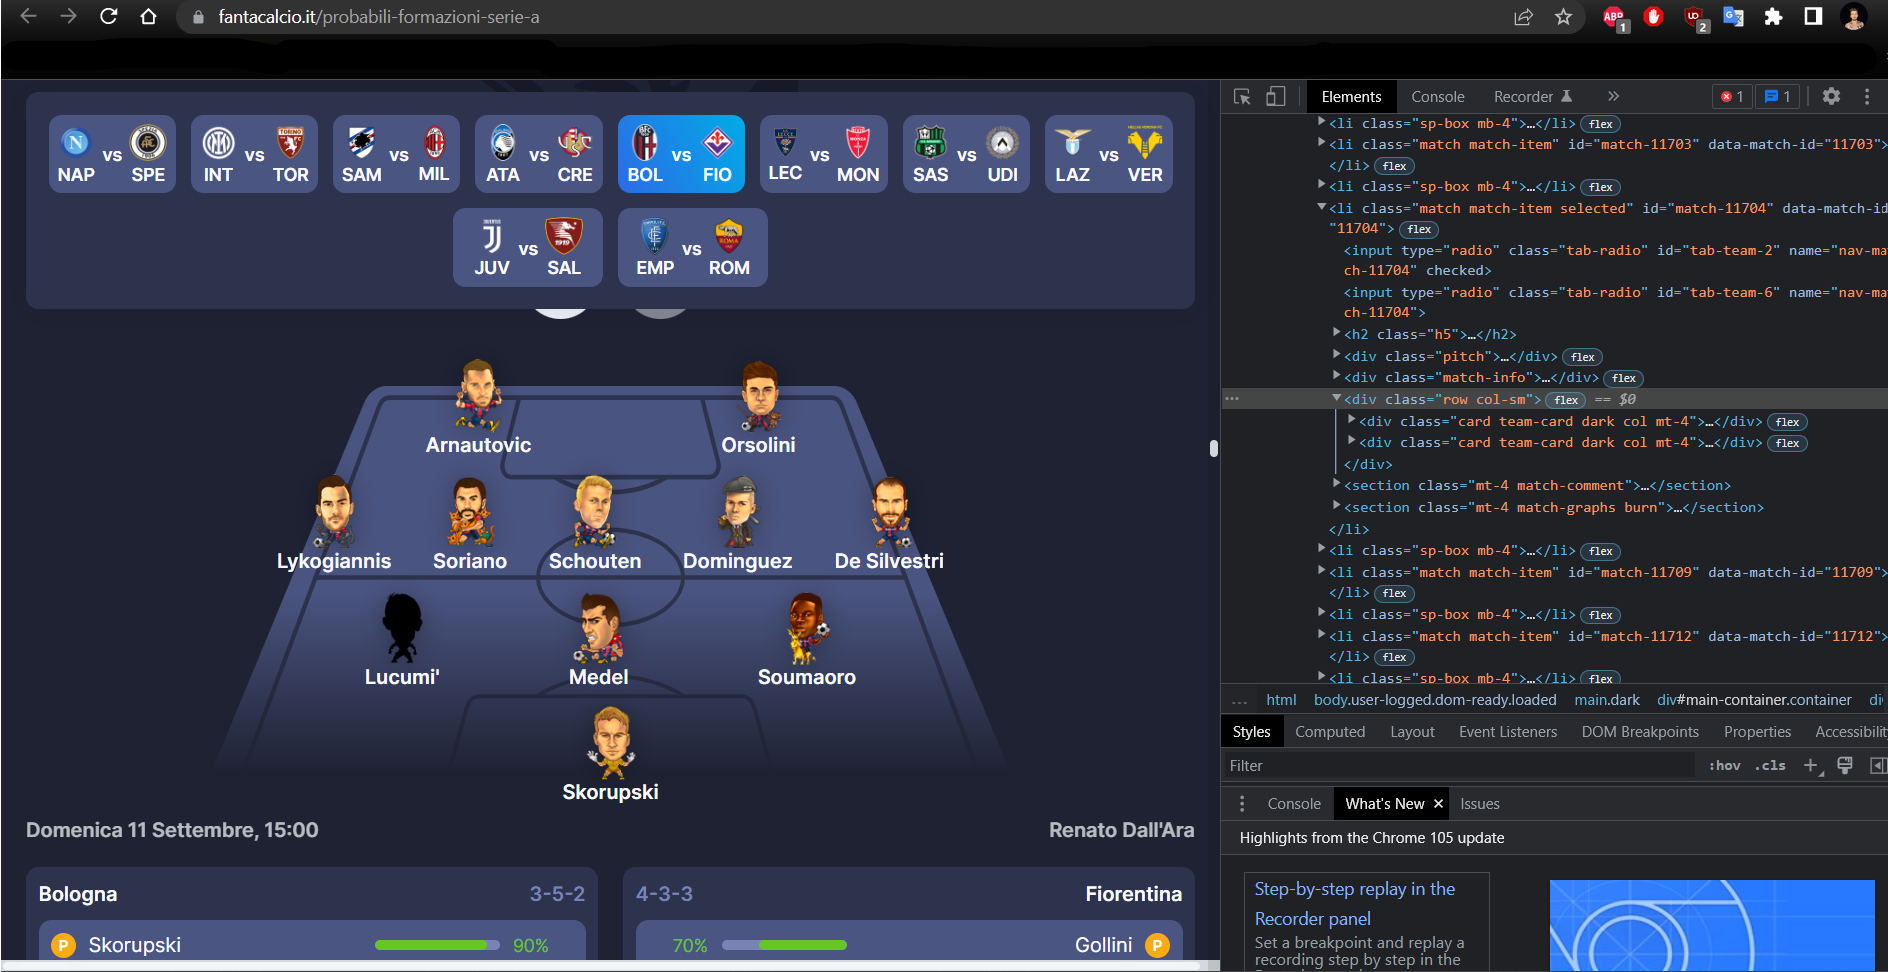

### Il prossimo passo è quello di  muoverci all’interno dei contenuti della pagina al fine di individuare in che punto del documento HTML si trovano le informazioni che ci interessano.

### Lo studio della struttura mostra come essa, a un certo punto, diventi ripetitiva: un tag 'li' delimita la sezione delle due formazioni in questione e al suo interno compare una serie di div che contengono i dati che vogliamo acquisire

In [3]:
# creazione di un oggetto "soup"
data = BeautifulSoup(resp.content)
# print(data)

paragrafo = data.find('ul', attrs = {'class': 'match-list'})
# print(paragrafo)

In [4]:
def scramping(paragrafo,start_index,end_match):
  p1=paragrafo.split("\n")
  p_new=[]
  for x in p1 :
    if x.strip()!='' and x.strip()!="," :
      p_new.append(x.strip())

  start=p_new[p_new.index("-")+1:].index("-")+(p_new.index("-")+1)+1
  dati_p=p_new[0+start_index:start+start_index]

  info_=p_new[start+22+start_index:] # 22 giocatori in campo, da 9+29 in poi abbiamo informazioni sulla partita e sulle rose

  info_partita=info_[0]
  stadio=info_[1]
  s1=info_[2:info_.index(dati_p[2].strip())]
  nome_squadra=s1[0]
  modulo=s1[1]
  giocatori=[]
  percentuale_di_giocare=[]
  is_titolare=[]
  squadra={"Nome squadra":nome_squadra,"Giocatori":giocatori,"Percentuale di gioco del giocatore":percentuale_di_giocare,"Titolare":is_titolare,"Match":dati_p[1].strip()+" VS "+dati_p[2].strip(),"Stadio Partita":stadio,"Info Partita":info_partita,"Modulo Partita":modulo,"Giornata N":dati_p[0].strip()}
  gg=s1[2:]

  titolari=gg[:gg.index("Panchina")]
  panchina=gg[gg.index("Panchina")+1:]

  in_campo=True
  for g in range (0,len(titolari),2):
    
    squadra["Giocatori"].append(titolari[g])
    squadra["Percentuale di gioco del giocatore"].append(titolari[g+1].strip())
    squadra["Titolare"].append(in_campo)

  in_campo=False
  for g in range (0,len(panchina),2):
    
    squadra["Giocatori"].append(panchina[g])
    squadra["Percentuale di gioco del giocatore"].append(panchina[g+1].strip())
    squadra["Titolare"].append(in_campo)

  df1=pd.DataFrame(squadra)


  s2=info_[info_.index(dati_p[2].strip()):info_.index("Presentazione squadre")]
  nome_squadra=s2[0]
  modulo=s2[1]
  giocatori=[]
  percentuale_di_giocare=[]
  is_titolare=[]
  squadra={"Nome squadra":nome_squadra,"Giocatori":giocatori,"Percentuale di gioco del giocatore":percentuale_di_giocare,"Titolare":is_titolare,"Match":dati_p[1].strip()+" VS "+dati_p[2].strip(),"Stadio Partita":stadio,"Info Partita":info_partita,"Modulo Partita":modulo,"Giornata N":dati_p[0].strip()}
  gg=s2[2:]
  # print(gg)
  titolari=gg[:gg.index("Panchina")]
  panchina=gg[gg.index("Panchina")+1:]

  # print(titolari,panchina)
  in_campo=True
  for g in range (0,len(titolari),2):
    
    squadra["Giocatori"].append(titolari[g])
    squadra["Percentuale di gioco del giocatore"].append(titolari[g+1].strip())
    squadra["Titolare"].append(in_campo)

  in_campo=False
  for g in range (0,len(panchina),2):
    
    squadra["Giocatori"].append(panchina[g])
    squadra["Percentuale di gioco del giocatore"].append(panchina[g+1].strip())
    squadra["Titolare"].append(in_campo)

  df2=pd.DataFrame(squadra)

  df=df1.append(df2)


  index_squalificati=info_.index("Squalificati")
  index_infortunati=info_.index("Infortunati")
  index_in_dubbio=info_.index("In dubbio")

  lista_infortunati=[]
  for x in info_[index_infortunati+1:index_in_dubbio]:
    if x!="Nessun calciatore":
      lista_infortunati.append(x)
  lista_squalificati=[]
  for x in info_[index_squalificati+1:index_infortunati]:
    if x!="Nessun calciatore":
      lista_squalificati.append(x)
  lista_indubbio=[]
  if end_match==True:
    limit_lista_indubbio=info_[index_in_dubbio+1:]
  else:
    limit_lista_indubbio=info_[index_in_dubbio+1:info_.index('6')]
  for x in limit_lista_indubbio:
    if x!="Nessun calciatore":
      lista_indubbio.append(x)
  # print(lista_indubbio,lista_infortunati,lista_squalificati)
  lista_infortunati_=[]
  lista_squalificati_=[]
  lista_indubbio_=[]


  for g in df["Giocatori"]:
    trovato_s=False
    for l in range (0,len(lista_squalificati),2):
      if g.strip()==lista_squalificati[l].strip():
        trovato_s=True
        lista_squalificati_.append(True.strip())
        break
    if trovato_s==False:
      lista_squalificati_.append(False)
    else:
      trovato_s=False

  for g in df["Giocatori"]:
    trovato_i=False
    for l in range (0,len(lista_infortunati),2):
      if g.strip()==lista_infortunati[l].strip():
        trovato_i=True
        lista_infortunati_.append(str(lista_infortunati[l+1]).strip())
        break
    if trovato_i==False:
      lista_infortunati_.append(str("No"))
    else:
      trovato_i=False

  for g in df["Giocatori"]:
    trovato_d=False
    for l in range (0,len(lista_indubbio),2):
      if g.strip()==lista_indubbio[l].strip():
        trovato_d=True
        lista_indubbio_.append(str(lista_indubbio[l+1]).strip())
        break
    if trovato_d==False:
      lista_indubbio_.append(str("No"))
    else:
      trovato_d=False

  df["Squalificato"]=lista_squalificati_
  df["Infortunato"]=lista_infortunati_
  df["In dubbio"]=lista_indubbio_


  squalificati_infortunati_indubbio={"Nome squadra":'',"Giocatori":[],"Percentuale di gioco del giocatore":[],"Titolare":False,"Match":dati_p[1].strip()+" VS "+dati_p[2].strip(),"Stadio Partita":stadio,"Info Partita":info_partita,"Modulo Partita":modulo,"Giornata N":dati_p[0].strip(),
                "Squalificato":[], "Infortunato":[], "In dubbio":[]}

  for l in range (0,len(lista_squalificati),2):
    trovato_s=False
    for g in df["Giocatori"]:
      if g.strip()==lista_squalificati[l].strip():
        trovato_s=True
        break
    if trovato_s==False:
      squalificati_infortunati_indubbio['Giocatori'].append(lista_squalificati[l])
      squalificati_infortunati_indubbio['Percentuale di gioco del giocatore'].append(0)
      squalificati_infortunati_indubbio['Squalificato'].append(True)
      squalificati_infortunati_indubbio['Infortunato'].append("No")
      squalificati_infortunati_indubbio['In dubbio'].append("No")
  
  for l in range (0,len(lista_infortunati),2):
    trovato_i=False
    for g in df["Giocatori"]:
      if g.strip()==lista_infortunati[l].strip():
        trovato_i=True
        break
    if trovato_i==False:
      squalificati_infortunati_indubbio['Giocatori'].append(lista_infortunati[l])
      squalificati_infortunati_indubbio['Percentuale di gioco del giocatore'].append("0%")
      squalificati_infortunati_indubbio['Squalificato'].append("No")
      squalificati_infortunati_indubbio['Infortunato'].append(lista_infortunati[l+1])
      squalificati_infortunati_indubbio['In dubbio'].append("No")
    
  for l in range (0,len(lista_indubbio),2):
    trovato_d=False
    for g in df["Giocatori"]:
      if g.strip()==lista_indubbio[l].strip():
        trovato_d=True
        break
    if trovato_d==False:
      squalificati_infortunati_indubbio['Giocatori'].append(lista_indubbio[l])
      squalificati_infortunati_indubbio['Percentuale di gioco del giocatore'].append("0%")
      squalificati_infortunati_indubbio['Squalificato'].append("No")
      squalificati_infortunati_indubbio['Infortunato'].append("No")
      squalificati_infortunati_indubbio['In dubbio'].append(lista_indubbio[l+1])

  squalificati_infortunati_indubbio=pd.DataFrame(squalificati_infortunati_indubbio)
  df=df.append(squalificati_infortunati_indubbio)

  if end_match==True:
    indice=len(info_)+start+22+start_index
  else:
    indice=info_.index('6')+start+22+start_index
  
  return df,indice



In [5]:
p = paragrafo.text

match_1,end=scramping(p,0, False)
match_2,end2=scramping(p,end, False)
match_3,end3=scramping(p,end2, False)
match_4,end4=scramping(p,end3, False)
match_5,end5=scramping(p,end4, False)
match_6,end6=scramping(p,end5, False)
match_7,end7=scramping(p,end6, False)
match_8,end8=scramping(p,end7, False)
match_9,end9=scramping(p,end8, False)
match_10,end10=scramping(p,end9, True)
len(match_1)+len(match_2)+len(match_3)+len(match_4)+len(match_5)+len(match_6)+len(match_7)+len(match_8)+len(match_9)+len(match_10)

507

In [6]:
df=match_1.append(match_2.append(match_3.append(match_4.append(match_5.append(match_6.append(match_7.append(match_8.append(match_9.append(match_10))))))))).rename_axis('Giocatore in rosa').reset_index()
df

,Giocatore in rosa,Nome squadra,Giocatori,Percentuale di gioco del giocatore,Titolare,Match,Stadio Partita,Info Partita,Modulo Partita,Giornata N,Squalificato,Infortunato,In dubbio
0,0,Napoli,Meret,90%,True,Napoli VS Spezia,Diego Armando Maradona,"sabato 10 settembre, 15:00",4-3-3,6,False,No,No
1,1,Napoli,Di Lorenzo,80%,True,Napoli VS Spezia,Diego Armando Maradona,"sabato 10 settembre, 15:00",4-3-3,6,False,No,No
2,2,Napoli,Rrahmani,80%,True,Napoli VS Spezia,Diego Armando Maradona,"sabato 10 settembre, 15:00",4-3-3,6,False,No,No
3,3,Napoli,Kim,60%,True,Napoli VS Spezia,Diego Armando Maradona,"sabato 10 settembre, 15:00",4-3-3,6,False,No,No
4,4,Napoli,Mario Rui,80%,True,Napoli VS Spezia,Diego Armando Maradona,"sabato 10 settembre, 15:00",4-3-3,6,False,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,4,,Kumbulla,0%,False,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,No,problema al bicipite femorale della coscia sin...,No
503,5,,Darboe,0%,False,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,No,"lesione al crociato destro, da valutare",No
504,6,,El Shaarawy,0%,False,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,No,"problema muscolo psoas della coscia sinistra, ...",No
505,7,,Zaniolo,0%,False,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,No,"problema alla spalla, tentativo di rientro per...",No


---
# Inserire la propria rosa del fantacalcio, i nostri 25 giocatori

In [7]:
Rosa_fantacalcio=[
    "Rui Patricio",
    "Szczesny",
    "Montipo'",
    "Milenkovic",
    "Di Lorenzo",
    "Danilo",
    "Kalulu",
    "Bremer",
    "Smalling",
    "Bastoni",
    "Bonucci",
    "Barella",
    "Luis Alberto",
    "Zaniolo",
    "Zielinski",
    "Kostic",
    "Tonali",
    "Miretti",
    "Pogba",
    "Vlahovic",
    "Dybala",
    "Giroud",
    "Jovic",
    "Pinamonti",
    "Caprari"
  ]
len(Rosa_fantacalcio)

25

In [8]:
def rosa_df(df,Rosa_fantacalcio):
  res=df.loc[df['Giocatori'] == Rosa_fantacalcio[0]]
  for g in range (1,len(Rosa_fantacalcio)):
    res=res.append(df.loc[df['Giocatori'] == Rosa_fantacalcio[g]])
  res.reset_index(drop=True)
  res.index = np.arange(1, len(res) + 1)
  return res
rosa=rosa_df(df,Rosa_fantacalcio)
print(len(rosa))
rosa

25


,Giocatore in rosa,Nome squadra,Giocatori,Percentuale di gioco del giocatore,Titolare,Match,Stadio Partita,Info Partita,Modulo Partita,Giornata N,Squalificato,Infortunato,In dubbio
1,0,Roma,Rui Patricio,90%,True,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,False,No,No
2,0,,Szczesny,0%,False,Juventus VS Salernitana,Allianz Stadium,"domenica 11 settembre, 20:45",3-5-2,6,No,"trauma caviglia destra, tentativo rientro 7a g...",No
3,0,Verona,Montipo',90%,True,Lazio VS Verona,Olimpico,"domenica 11 settembre, 18:00",3-5-2,6,False,No,No
4,0,,Milenkovic,0%,False,Bologna VS Fiorentina,Renato Dall'Ara,"domenica 11 settembre, 15:00",4-3-3,6,No,lesione di basso grado all’adduttore breve del...,No
5,1,Napoli,Di Lorenzo,80%,True,Napoli VS Spezia,Diego Armando Maradona,"sabato 10 settembre, 15:00",4-3-3,6,False,No,No
6,1,Juventus,Danilo,55%,True,Juventus VS Salernitana,Allianz Stadium,"domenica 11 settembre, 20:45",4-3-3,6,False,No,No
7,2,Milan,Kalulu,85%,True,Sampdoria VS Milan,Luigi Ferraris,"sabato 10 settembre, 20:45",4-2-3-1,6,False,No,No
8,3,Juventus,Bremer,55%,True,Juventus VS Salernitana,Allianz Stadium,"domenica 11 settembre, 20:45",4-3-3,6,False,No,No
9,2,Roma,Smalling,80%,True,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,False,No,No
10,3,Inter,Bastoni,70%,True,Inter VS Torino,Giuseppe Meazza,"sabato 10 settembre, 18:00",3-5-2,6,False,No,No


Ora andiamo ad utilizzare un dataset scaricabile dal seguente link che ci siamo ricavati per avere maggiori informazioni sui nostri giocatori

In [9]:
URL = "https://www.fantacalcio.it/quotazioni-fantacalcio"
resp1 = requests.get(URL)
print(resp1.status_code)
# print(resp1.content)

200


In [10]:
# creazione di un oggetto "soup"
data2 = BeautifulSoup(resp1.content)
paragrafo2 = data2.find('header', attrs = {'class': 'mb-3 d-flex align-items-center'})

In [11]:
link=str(paragrafo2).split("href=")[1]
link="https://www.fantacalcio.it"+link.split("\" ")[0][1:]
print(link)
dati = pd.read_excel('/content/drive/MyDrive/project/Dataset/Quotazioni_Fantacalcio_Stagione_2022_23.xlsx',header=1)
dati

https://www.fantacalcio.it/api/v1/Excel/prices/17/1


,Id,R,RM,Nome,Squadra,Qt.A,Qt.I,Diff.,Qt.A M,Qt.I M,Diff.M,FVM,FVM M
0,4312,P,Por,Maignan,Milan,19,18,1,19,18,1,91,91
1,572,P,Por,Meret,Napoli,16,14,2,16,14,2,50,50
2,2792,P,Por,Musso,Atalanta,15,13,2,15,13,2,37,37
3,453,P,Por,Szczesny,Juventus,14,16,-2,14,16,-2,65,65
4,250,P,Por,Handanovic,Inter,13,16,-3,13,16,-3,60,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,5505,A,Pc,Kaio Jorge,Juventus,1,1,0,1,1,0,1,1
550,5734,A,A,Soule',Juventus,1,1,0,1,1,0,1,1
551,5785,A,Pc,Lazetic,Milan,1,1,0,1,1,0,1,1
552,5837,A,Pc,Voelkerling Persson,Lecce,1,1,0,1,1,0,1,1


Ora si andrà ad effettuare una specie di join per riuscire ad aumentare i dati della nostra rosa

In [12]:
ind=[]
ruolo=[]
ruolo_fanta=[]
squadra=[]
fvm=[]
for r in rosa['Giocatori']:
  for g in dati['Nome']:
    if r==g:
      player=dati.loc[dati['Nome']==g]      
      ruolo.append(player['RM'].values[0])#.values[0])
      ruolo_fanta.append(player['R'].values[0])
      squadra.append(player['Squadra'].values[0])
      fvm.append(player['FVM'].values[0])
  
rosa["Ruolo"]=ruolo
rosa["Ruolo Fanta"]=ruolo_fanta
rosa["Nome squadra"]=squadra
rosa["FVM"]=fvm
rosa

,Giocatore in rosa,Nome squadra,Giocatori,Percentuale di gioco del giocatore,Titolare,Match,Stadio Partita,Info Partita,Modulo Partita,Giornata N,Squalificato,Infortunato,In dubbio,Ruolo,Ruolo Fanta,FVM
1,0,Roma,Rui Patricio,90%,True,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,False,No,No,Por,P,47
2,0,Juventus,Szczesny,0%,False,Juventus VS Salernitana,Allianz Stadium,"domenica 11 settembre, 20:45",3-5-2,6,No,"trauma caviglia destra, tentativo rientro 7a g...",No,Por,P,65
3,0,Verona,Montipo',90%,True,Lazio VS Verona,Olimpico,"domenica 11 settembre, 18:00",3-5-2,6,False,No,No,Por,P,20
4,0,Fiorentina,Milenkovic,0%,False,Bologna VS Fiorentina,Renato Dall'Ara,"domenica 11 settembre, 15:00",4-3-3,6,No,lesione di basso grado all’adduttore breve del...,No,Dd;Dc,D,30
5,1,Napoli,Di Lorenzo,80%,True,Napoli VS Spezia,Diego Armando Maradona,"sabato 10 settembre, 15:00",4-3-3,6,False,No,No,Dd;E,D,42
6,1,Juventus,Danilo,55%,True,Juventus VS Salernitana,Allianz Stadium,"domenica 11 settembre, 20:45",4-3-3,6,False,No,No,Dd;Ds;E,D,30
7,2,Milan,Kalulu,85%,True,Sampdoria VS Milan,Luigi Ferraris,"sabato 10 settembre, 20:45",4-2-3-1,6,False,No,No,Dd;Dc,D,34
8,3,Juventus,Bremer,55%,True,Juventus VS Salernitana,Allianz Stadium,"domenica 11 settembre, 20:45",4-3-3,6,False,No,No,Dc,D,53
9,2,Roma,Smalling,80%,True,Empoli VS Roma,Carlo Castellani,"lunedì 12 settembre, 20:45",3-4-2-1,6,False,No,No,Dc,D,33
10,3,Inter,Bastoni,70%,True,Inter VS Torino,Giuseppe Meazza,"sabato 10 settembre, 18:00",3-5-2,6,False,No,No,Dc,D,35


---
# Visualizzazione della possibilità di partecipare alla prossima partita dei nostri giocatori

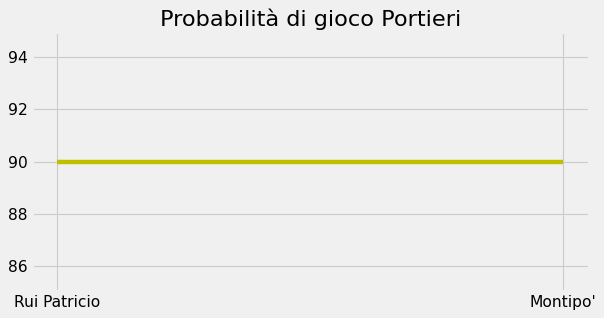

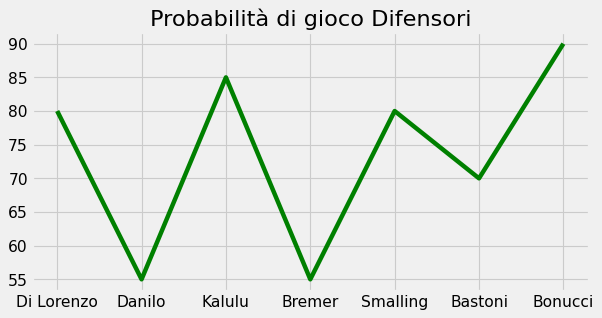

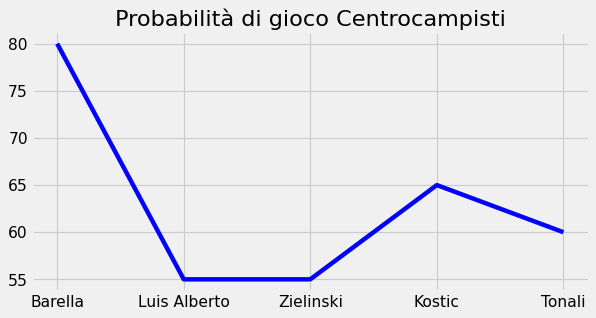

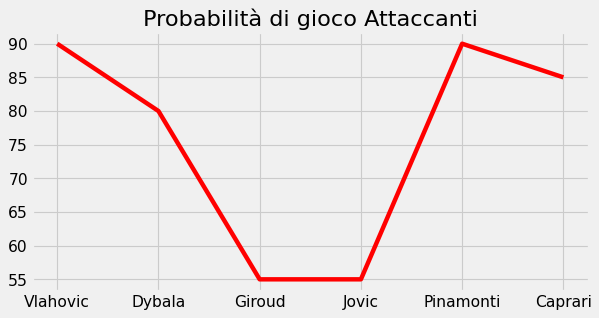

In [13]:
def plt_bar_roles(ruolo,titl,col):
  g=rosa.loc[rosa['Ruolo Fanta']==ruolo ]
  g=g.loc[rosa['Titolare']==True ]
  
  val=g['Percentuale di gioco del giocatore'].values
  for v in range (len(val)):
    val[v]=int (val[v][:len(val[v])-1])

  ris={'Giocatori':g['Giocatori'],'Percentuale di gioco':val}

  plt.figure(figsize=(8, 4), dpi=80)
  plt.plot(g['Giocatori'],val,color = col)
  # plt.pie(val,labels=g['Giocatori'])
  plt.title("Probabilità di gioco "+titl)
  plt.show()

plt_bar_roles('P','Portieri','y')
plt_bar_roles('D','Difensori','g')
plt_bar_roles('C','Centrocampisti','b')
plt_bar_roles('A','Attaccanti','r')

Aggiungiamo eventuali altri giocatori per completare gli 11 titolari e 7 in panchina, se non già presenti.

In [14]:
def aggiungi(ruolo,g,rosa,qnt):
  indexNames=[]
  for n in g['Giocatori'].values:
    i=rosa[rosa['Giocatori'] ==n].index
    indexNames.append(i[0])
  rosa=rosa.drop(index=indexNames)
  
  val=rosa['Percentuale di gioco del giocatore'].values
  fvm_top=rosa['FVM'].values

  for v in range (len(val)):
    val[v]=int (val[v][:len(val[v])-1])

  ris={'Giocatori':rosa['Giocatori'],'Ruolo':rosa['Ruolo Fanta'],'Percentuale di gioco':val,"FVM":fvm_top}
  r=pd.DataFrame(ris)
  r['Sort']=(r['FVM']+r['Percentuale di gioco'])/2
  r = r.sort_values(['Sort'], ascending=False)
  r=r.loc[r['Ruolo']==ruolo]
  g=g.append(r.head(qnt))
  return g


def controlla(formazione,rosa):
  if len(formazione.loc[formazione['Ruolo']=='A' ])<5:
    # print("A")
    formazione=aggiungi('A',formazione,rosa,5-len(formazione.loc[formazione['Ruolo']=='A' ]))
  if len(formazione.loc[formazione['Ruolo']=='C' ])<6:
    # print("C")
    formazione=aggiungi('C',formazione,rosa,6-len(formazione.loc[formazione['Ruolo']=='C' ]))
  if len(formazione.loc[formazione['Ruolo']=='D' ])<5:
    # print("D")
    formazione=aggiungi('D',formazione,rosa,5-len(formazione.loc[formazione['Ruolo']=='D' ]))
  if len(formazione.loc[formazione['Ruolo']=='P' ])<2:
    # print("P")
    formazione=aggiungi('P',formazione,rosa,2-len(formazione.loc[formazione['Ruolo']=='P' ]))
  # print(len(formazione.loc[formazione['Ruolo']=='C' ]))
  return formazione


# g=rosa
g=rosa.loc[rosa['Titolare']==True ]
val=g['Percentuale di gioco del giocatore'].values
fvm_top=g['FVM'].values

for v in range (len(val)):
  val[v]=int (val[v][:len(val[v])-1])

ris={'Giocatori':g['Giocatori'],'Ruolo':g['Ruolo Fanta'],'Percentuale di gioco':val,"FVM":fvm_top}

formazione=pd.DataFrame(ris)

formazione=controlla(formazione,rosa).reset_index(drop=True)
formazione['Sort']=(formazione['FVM']+formazione['Percentuale di gioco'])/2

In [15]:
# formazione = formazione.sort_values(['FVM','Percentuale di gioco'], ascending=False)
formazione = formazione.sort_values(['Sort'], ascending=False)
formazione

,Giocatori,Ruolo,Percentuale di gioco,FVM,Sort
14,Vlahovic,A,90,390,240.0
15,Dybala,A,80,210,145.0
16,Giroud,A,55,180,117.5
18,Pinamonti,A,90,120,105.0
17,Jovic,A,55,120,87.5
19,Caprari,A,85,68,76.5
9,Barella,C,80,63,71.5
11,Zielinski,C,55,87,71.0
0,Rui Patricio,P,90,47,68.5
2,Di Lorenzo,D,80,42,61.0


In [16]:
def titolari_panchina(formazione,Ruolo,n_tit,n_panc):
  titolari_top=formazione.loc[formazione['Ruolo']==Ruolo ]
  titolari=titolari_top.head(n_tit)
  titolari_top=titolari_top.drop(index=titolari.index)
  panchina=titolari_top.head(n_panc)
  return titolari,panchina

---
# Formazioni da schierare

In [17]:
attaccanti_titolari,attaccanti_panchinari= titolari_panchina(formazione,'A',3,2)
centrocampisti_titolari,centrocampisti_panchinari= titolari_panchina(formazione,'C',4,2)
difensori_titolari,difensori_panchinari= titolari_panchina(formazione,'D',3,2)
portieri_titolari,portieri_panchinari= titolari_panchina(formazione,'P',1,1)

formazione_titolare=portieri_titolari.append(difensori_titolari.append(centrocampisti_titolari.append(attaccanti_titolari))).reset_index(drop=True)
formazione_titolare.index = np.arange(1, len(formazione_titolare) + 1)
formazione_titolare['Giocatore in']='campo'
formazione_titolare

,Giocatori,Ruolo,Percentuale di gioco,FVM,Sort,Giocatore in
1,Rui Patricio,P,90,47,68.5,campo
2,Di Lorenzo,D,80,42,61.0,campo
3,Kalulu,D,85,34,59.5,campo
4,Bonucci,D,90,28,59.0,campo
5,Barella,C,80,63,71.5,campo
6,Zielinski,C,55,87,71.0,campo
7,Luis Alberto,C,55,65,60.0,campo
8,Kostic,C,65,43,54.0,campo
9,Vlahovic,A,90,390,240.0,campo
10,Dybala,A,80,210,145.0,campo


In [18]:
formazione_panchina=portieri_panchinari.append(difensori_panchinari.append(centrocampisti_panchinari.append(attaccanti_panchinari))).reset_index(drop=True)
formazione_panchina.index = np.arange(1, len(formazione_panchina) + 1)
formazione_panchina['Giocatore in']='panchina'
formazione_panchina

,Giocatori,Ruolo,Percentuale di gioco,FVM,Sort,Giocatore in
1,Montipo',P,90,20,55.0,panchina
2,Smalling,D,80,33,56.5,panchina
3,Bremer,D,55,53,54.0,panchina
4,Tonali,C,60,45,52.5,panchina
5,Miretti,C,55,26,40.5,panchina
6,Pinamonti,A,90,120,105.0,panchina
7,Jovic,A,55,120,87.5,panchina


---
# Scriviamo il dataset ottenuto in un file csv

In [19]:
formazione_finale=formazione_titolare.append(formazione_panchina)
formazione_finale.index = np.arange(1, len(formazione_finale) + 1)
formazione_finale

,Giocatori,Ruolo,Percentuale di gioco,FVM,Sort,Giocatore in
1,Rui Patricio,P,90,47,68.5,campo
2,Di Lorenzo,D,80,42,61.0,campo
3,Kalulu,D,85,34,59.5,campo
4,Bonucci,D,90,28,59.0,campo
5,Barella,C,80,63,71.5,campo
6,Zielinski,C,55,87,71.0,campo
7,Luis Alberto,C,55,65,60.0,campo
8,Kostic,C,65,43,54.0,campo
9,Vlahovic,A,90,390,240.0,campo
10,Dybala,A,80,210,145.0,campo


In [20]:
formazione_finale.to_excel("/content/drive/MyDrive/project/Dataset/formazione_finale_da schierare.xlsx")